In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
from scipy.stats import pearsonr,spearmanr

In [3]:
from gplearn.genetic import SymbolicRegressor,SymbolicTransformer
from gplearn import fitness
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

In [4]:
# 自定义算子
def _Add(data1,data2):
    if len(np.unique(data1))<=1 or len(np.unique(data2))<=1:
        return np.zeros(len(data1))
    else:
        return np.add(data1,data2)
    
def _Sub(data1,data2):
    if len(np.unique(data1))<=1 or len(np.unique(data2))<=1:
        return np.zeros(len(data1))
    else:
        return np.subtract(data1,data2)
    
def _Mul(data1,data2):
    if len(np.unique(data1))<=1 or len(np.unique(data2))<=1:
        return np.zeros(len(data1))
    else:
        return np.multiply(data1,data2)
    
def _Div(data1,data2):
    def protect_division(data1,data2):
        with np.errstate(divide='ignore',invalid='ignore'):
            return np.where(np.abs(data2)>0.001,np.divide(data1,data2),0.)
    if len(np.unique(data1))<=1 or len(np.unique(data2))<=1:
        return np.zeros(len(data1))
    else:
        return protect_division(data1,data2)
    
def _Sqrt(data):
    if len(np.unique(data))<=1:
        return np.zeros(len(data))
    else:
        return np.sqrt(np.abs(data))
    
def _Log(data):
    def protect_log(data):
        with np.errstate(divide='ignore',invalid='ignore'):
            return np.where(np.abs(data) > 0.001, np.log(np.abs(data)), 0.)
    if len(np.unique(data))<=1:
        return np.zeros(len(data))
    else:
        return protect_log(data)
    
def _Inv(data):
    data=np.array(data)
    def protect_inv(data):
        with np.errstate(divide='ignore',invalid='ignore'):
            return np.where(np.abs(data) > 0.001, 1./data, 0.)
    if len(np.unique(data))<=1:
        return np.zeros(len(data))
    else:
        return protect_inv(data)

def _ts_max(data,window): #历史rolling最大
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).max())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))

def _ts_min(data,window): #历史rolling最小
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).min())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))

def _ts_mid(data,window): #历史rolling中位数
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).median())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))


def _ts_mean(data,window):  #历史rolling平均
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).mean())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))


def _ts_std(data,window): #历史rolling std
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).std())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))
    
    
def _ts_sum(data,window): #历史rolling求和
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).mean())
        return np.nan_to_num(value.values*window)
    except:
        return np.zeros(len(data))
    
    
def _ts_product(data,window): #历史rolling求积
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':np.log(data)})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).mean())
        return np.nan_to_num(np.exp(value.values*window))
    except:
        return np.zeros(len(data))

    
def _delay(data,window):  # 几天以前的因子值
    window=window[0]
    if window not in [1,5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x : x.shift(window))
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))

    
def _delta(data,window):  # 因子值与几天前的因子值之差
    window=window[0]
    if window not in [1,5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x : x.shift(window))
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))

    
def _rank(data):  # 因子在截面上的分位数
    if len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('date')['data'].transform(lambda s : s.rank()/s.count())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))
    
    
def _ts_rank(data,window):  # 因子在过去几天中的分位数
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code  
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).rank()/window)
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))
    
    
def _sigmoid(data):
    data=np.array(data)
    with np.errstate(over='ignore',under='ignore'):
        return 1/(1+np.exp(-1*data))
    
    
def _correlation(data1,data2,window):
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data1))<=2 or len(np.unique(data2))<=2:
        return np.zeros(len(data1))
    try:
        df=pd.DataFrame({'data1':data1,'data2':data2})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code').apply(lambda df : df.data1.rolling(window).corr(df.data2)) # 因为code排序是按顺序的所以可以用apply
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data1))
    
    
def _covariance(data1,data2,window):
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data1))<=2 or len(np.unique(data2))<=2:
        return np.zeros(len(data1))
    try:
        df=pd.DataFrame({'data1':data1,'data2':data2})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code').apply(lambda df : df.data1.rolling(window).cov(df.data2)) # 因为code排序是按顺序的所以可以用apply
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data1))
    
    
def _scale(data):
    if len(np.unique(data))<=2:
        return np.zeros(len(data))
    else:
        return np.divide(data,np.sum(np.abs(data)))
    
    
def _decay_linear(data,window):  # 因子过去几天的加权平均值，权数随时间往前线性递减
    window=window[0]    
    if  window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        w=np.arange(1,window+1)
        w=w/np.sum(w)
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code').data.transform(lambda x:x.rolling(window).apply(lambda s:np.dot(w,s.values)).values)
        return np.nan_to_num(value)
    except:
        return np.zeros(len(data))
Add=make_function(function=_Add,name='Add',arity=2)
Sub=make_function(function=_Sub,name='Sub',arity=2)
Mul=make_function(function=_Mul,name='Mul',arity=2)
Div=make_function(function=_Div,name='Div',arity=2)
Log=make_function(function=_Log,name='Log',arity=1)
Sqrt=make_function(function=_Sqrt,name='Sqrt',arity=1)
Inv=make_function(function=_Inv,name='Inv',arity=1)
ts_max=make_function(function=_ts_max,name='ts_max',arity=2) 
ts_min=make_function(function=_ts_min,name='ts_min',arity=2) 
ts_mid=make_function(function=_ts_mid,name='ts_mid',arity=2) 
ts_mean=make_function(function=_ts_mean,name='ts_mean',arity=2) 
ts_std=make_function(function=_ts_std,name='ts_std',arity=2)
delay=make_function(function=_delay,name='delay',arity=2)
delta=make_function(function=_delta,name='delta',arity=2)
rank=make_function(function=_rank,name='rank',arity=1)
sigmoid=make_function(function=_sigmoid,name='sigmoid',arity=1)
correlation=make_function(function=_correlation,name='correlation',arity=3)
covariance=make_function(function=_covariance,name='covariance',arity=3)
scale=make_function(function=_scale,name='scale',arity=1)
ts_rank=make_function(function=_ts_rank,name='ts_rank',arity=2)
ts_sum=make_function(function=_ts_sum,name='ts_sum',arity=2)
ts_product=make_function(function=_ts_product,name='ts_product',arity=2)

In [5]:
post=ff.read('post')
filter0=ff.filter0
close=ff.read('close')*post*filter0
open_=ff.read('open')*post*filter0
high=ff.read('high')*post*filter0
low=ff.read('low')*post*filter0
vol=ff.read('vol')*filter0
amount=ff.read('amount')*post*filter0

In [6]:
inds = pd.read_pickle('/mydata2/wangs/data/dict_ind_matrix_sw1.pk')

In [7]:
result = pd.DataFrame(columns=['因子','夏普率','收益率','mkt_'])

In [8]:
mkv=(ff.read('mkv','factor')*filter0).loc[close.index,'20200101':'20210101']
mkv_s=mkv.values.reshape(-1)

In [9]:
mkt20=close.shift(-1,axis=1)/close - 1

In [10]:
factor_names1=['closer', 'openr', 'lowr', 'highr', 'ocret', 'lcret', 'hcret', 'ohret', 'ret5', 'ret10', 'ret20', 'ret30', 'excess5', 'excess10', 'excess20', 'excess30', 'ma5', 'bias5', 'ma10',
               'bias10', 'ma15', 'bias15', 'ma20', 'bias20', 'vwap_ret', 'vwaph_ret', 'll5', 'll15', 'll20', 'll30', 'a0', 'a5', 'a15', 'a30', 'ah5', 'ah10', 'ah15', 'std', 'amt_std', 'vol_std', 
               'amt_mean', 'vol_mean', 'turnover', 'turnover_mean', 'turnover_std', 'turnover_skew', 'turnoverf', 'turnoverf_mean', 'turnoverf_std', 'turnoverf_skew', 'mkv', 'l_mkv', 'lhret', 
               'STR', 'MTR', 'SMTR', 'ILLIQ','close','high','low']
factor_names2=['ARRP', 'ARRP_5d_20mean', 'AmpMod', 'BVol', 'CDPDVP', 'ILLIQ', 'IVoldeCorr', 'IntraDayMom20', 'MTR', 'RCP', 'SMTR', 'SPS', 'STR', 'a30', 
               'afternoon_ratio_1', 'ah15', 'amt', 'amt_ma20', 'amt_mean', 'amt_score0', 'amt_score1', 'amt_score2', 'amt_std', 'amt_std20', 'bias10', 'bias15', 'bias20', 'bias5', 
               'cross_std10', 'cross_std10adj', 'ctrade', 'excess10', 'excess20', 'excess30', 'excess5', 'growth_a', 'growth_b', 'growth_c', 'h_rankamt_corr_10', 'h_rankv_corr_10', 'h_rankv_corr_36', 
               'hcret', 'idiov', 'intro_high80_corr', 'ivr', 'l_mkv', 'mkv', 'mom1', 'mom_spring', 'nl_mkv', 'nl_mom', 'open0931ratio', 'open5ratio_ma10vol', 'rank_2_corr_hv10', 'rank_2_corr_hv20', 'rank_ha_corr_sum', 
               'ret20', 'ret30', 'ret5', 'roc121', 'roc20', 'roc240', 'roc5', 'scr', 'std', 'std20', 'std21', 'std240', 'stddev_cov', 'stddev_cov_right', 'sub', 'sysv', 'tail_ratio_1', 'tailrets0', 'tailrets1', 'tliq', 
               'turn20', 'turnover', 'turnover_mean', 'turnover_scale_z', 'turnover_score_ts_mean', 'turnover_score_ts_std', 'turnover_skew', 'turnover_std', 'turnoverf', 'turnoverf_mean', 'turnoverf_skew', 'turnoverf_std', 
               'up_KURS', 'up_plus_down_KURS', 'vol', 'vol_mean', 'vol_std', 'vol_std20', 'volroc_skew', '滞后日内量价corr']
factor_name3 =['accelerated_turnover_rank_RC','CSK_XYY_UP_DOWN_120D_RC','high_fre_vol_RC','high_fre_diff_vol_RC','high_fre_absdiff_vol_RC','peak_count_vol_RC','overnightsmart20_RC','CTR_RC','jumpCTR_RC','turnover_rate_proportion_l','synergy']
factor_name4 = ['ll60','ll120', 'lr5', 'lr10', 'lr20', 'lr30','lr60','lr120','posi60','posi120','posi240','nhigh20','nhigh60', 'nhigh120','nhigh20','nhigh60','nhigh120']
factor_name5 = ['rtn_condVaR', 'CTR_RC', 'jumpCTR_RC', 'openr', 'CCOIV', 'lr30', 'SZXZ', 'vol_DW', 'buy_sm_amount', 'lr20', 'TCV', 'ah10', 'buy_elg_amount', 'ret10', 'vol_LBQ', 'ah5', 'lr120', 'ma15', 'correlation_matrix13', 'high_fre_diff_vol', 'posi120', 'nlow60', 'roc30', 'accelerated_turnover_rank', 'VolStd', 'low', 'sell_sm_amount', 'vwap_ret', 'rtn_DW', 'high', 'sell_md_amount', 'll5', 'SBZL', 'lhret', 'nhigh120', 'SQ', 'draw30', 'lr60', 'SPR', 'close', 'rtn_LBQ', 'WBGM', 'closer', 'SCOV', 'll60', 'feph', 'ID_Vol_deCorr', 'highr', 'NCV', 'buy_md_amount', 'lcret', 'SCCOIV', 'VoPC', 'highStdRtn_meanN', 'lowr', 'up', 'nhigh20', 'll20', 'high_fre_vol', 'ma5', 'ZMCW', 'bias30', 'high_fre_absdiff_vol', 'a5', 'nlow120', 'UID', 'll15', 'sell_elg_amount', 'posi60', 'a0', 'ma20', 'roc60', 'correlation_matrix12', 'overnightsmart20_RC', 'peak_count_vol', 'roc15', 'lr10', 'VoWVR', 'rtn_rho', 'nhigh60', 'down', 'posi240', 'foc_Comb', 'vwaph_ret', 'vol_rho', 'GYCQ', 'draw60', 'up_limit', 'post', 'PCV', 'UTD10', 'RPV', 'buy_lg_amount', 'draw15', 'ocret', 'ma10', 'll30', 'rtn_foc', 'sell_lg_amount', 'vwap', 'YMSL', 'ohret', 'net_mf_amount', 'DW_Comb', 'market_mean_IV', 'CSK_XYY_UP_DOWN_120D', 'correlation_matrix11', 'down_limit', 'HYLJ', 'nlow20', 'bias60', 'SRV', 'LBQ_Comb', 'UTD20', 'open', 'a15', 'COYCYV', 'rho_Comb', 'll120', 'highStdRtn_mean', 'lr5', 'vol_foc']
fields = factor_names1 + factor_names2 + factor_name3 + factor_name4 + factor_name5
fields = list(set(fields))

In [11]:
stock_test=pd.DataFrame()
for factor in fields:
    data = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20210101'].columns)
    stock_test[factor] = (data.rank()/data.count()).values.reshape(-1)
test_code=[code for code in close.index for i in close.loc[:,'20200101':'20210101'].columns]
test_date=close.loc[:,'20200101':'20210101'].columns.to_list() *len(close.index)
stock_test['code']=test_code
stock_test['date']=test_date
stock_test['1'],stock_test['5'],stock_test['10'],stock_test['20'],stock_test['40'],stock_test['60']=1,5,10,20,40,60

In [12]:
test_mkt = mkt20.loc[:,'20200101':'20210101'].values.reshape(-1)
# test_mkt=(mkt20.loc[:,'20200101':'20210101'].rank()/mkt20.loc[:,'20200101':'20210101'].count()).values.reshape(-1)

In [13]:
init_function = ['add','sub','mul','div','sqrt','log','inv','abs','neg']
user_function=[ts_max,ts_min,ts_mid,ts_mean,ts_std,delay,delta,rank,correlation,ts_rank]
function_set=init_function+user_function

In [14]:
import statsmodels.api as sm
close_ = ff.read('close').loc[:,'20200101':'20210101']
ret = (close_ - close_.shift(axis = 1))/close_.shift(axis = 1)
def ret_100_matrix(y,y_pred,w=None):
    def ret_100(test_df):
        day = test_df['date'].values[0]
        test_df.index = test_df['code'].values
        test_df = test_df.loc[:,('y_pred')].copy()
        buy_stock =  (ff.filter1[day] * test_df).dropna().sort_values().head(100).index
        #print('day',day,'ret:',ret.shift(-1,axis = 1).loc[buy_stock][day].mean())
        return ret.shift(-1,axis = 1).loc[buy_stock][day].mean()

    if len(np.unique(y_pred))<=2:
        return 0
    else:
        data=pd.DataFrame({'y_pred':y_pred,'code':test_code,'date':test_date})
        res=data.groupby('date').apply(ret_100)
        res['20201231'] = 0
        # print('sharp',ff.cal_returns(res)['夏普率'])
        return ff.cal_returns(res)['年化收益率']

In [15]:
ret_100_fun=make_fitness(function=ret_100_matrix,greater_is_better=True)

In [16]:
test_gp=SymbolicTransformer(feature_names = fields,
                            function_set = function_set, #所有算子
                            generations = 4, #进化代数
                            population_size = 10000, #种群规模
                            tournament_size = 10, #竞标赛规模
                            p_crossover=0.4,
                            p_subtree_mutation=0.05,
                            p_hoist_mutation=0.01,
                            p_point_mutation=0.03,
                            p_point_replace=0.35,
                            init_depth=(1,4),
                            const_range = None,
                            metric=ret_100_fun,
                            parsimony_coefficient = 'auto',
                            low_memory=True,
                            verbose=2,
                            n_jobs = 6)

In [17]:
test_gp.fit(np.nan_to_num(stock_test.loc[:,fields].values),np.nan_to_num(test_mkt))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 15.8min remaining: 31.6min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 16.3min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


   0     6.42       0.00797189        3         0.692879              N/A     49.06m


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 33.9min remaining: 67.9min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 34.8min finished


   1     4.14         0.223293        7         0.833695              N/A     69.54m


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 36.8min remaining: 73.5min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 39.3min finished


   2     4.66         0.346836        7         0.833695              N/A     39.31m


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 45.4min remaining: 90.8min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 49.4min finished


   3     4.92          0.46965        3         0.919137              N/A      0.00s


SymbolicTransformer(const_range=None,
                    feature_names=['posi240', 'turnoverf', 'a5', 'ARRP',
                                   'amt_score0', 'stddev_cov_right',
                                   'peak_count_vol_RC', 'excess5', '滞后日内量价corr',
                                   'turnover_rate_proportion_l', 'volroc_skew',
                                   'll60', 'lr5', 'highr', 'amt_std20',
                                   'afternoon_ratio_1', 'open0931ratio',
                                   'peak_count_vol', 'std20', 'mkv', 'vol',
                                   'draw30', 'VoWVR', 'tailrets0', 'nl_mom',
                                   'u...
                                  <gplearn.functions._Function object at 0x7f6926235d90>,
                                  <gplearn.functions._Function object at 0x7f6926235f10>],
                    generations=4, init_depth=(1, 4), low_memory=True,
                    metric=<gplearn.fitness._Fitness object at 0x7f68c45b6280>,
                    n_jobs=6, p_crossover=0.4, p_point_mutation=0.03,
                    p_point_replace=0.35, p_subtree_mutation=0.05,
                    parsimony_coefficient='auto', population_size=10000,
                    tournament_size=10, verbose=2)

In [18]:
stock_all=pd.DataFrame()
for factor in fields:
    # stock_all[factor] = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20240101'].columns).values.reshape(-1)
    data = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20240101'].columns)
    stock_all[factor] = (data.rank()/data.count()).values.reshape(-1)
test_code=[code for code in close.index for i in close.loc[:,'20200101':'20240101'].columns]
test_date=close.loc[:,'20200101':'20240101'].columns.to_list() *len(close.index)
stock_all['code']=test_code
stock_all['date']=test_date
stock_all['1'],stock_all['5'],stock_all['10'],stock_all['20'],stock_all['40'],stock_all['60']=1,5,10,20,40,60

Program 1: sub(bias15, ctrade)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


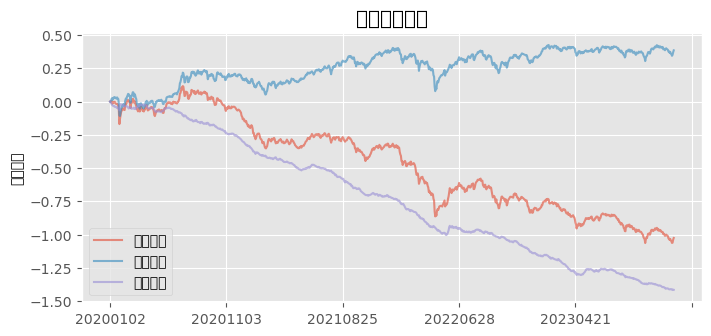

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.365,-0.264
年化波动率,0.201,0.070,0.209
夏普率,0.495,-5.176,-1.267
最大回撤,-0.325,-1.408,-1.180
收益回撤比,0.305,-0.259,-0.224
胜率,0.534,0.334,0.492
盈亏比,0.948,0.832,0.828


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


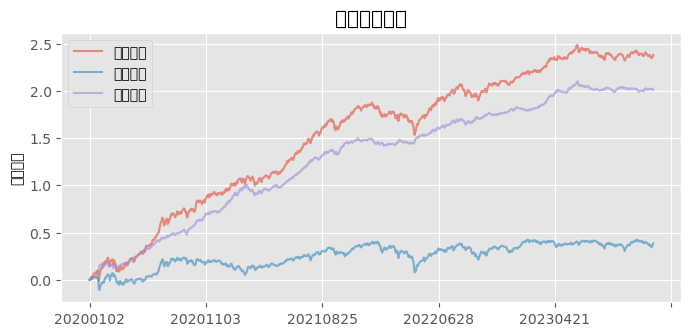

,指数收益,超额收益,策略收益
年化收益率,0.099,0.520,0.614
年化波动率,0.201,0.144,0.265
夏普率,0.495,3.619,2.315
最大回撤,-0.325,-0.113,-0.341
收益回撤比,0.305,4.607,1.801
胜率,0.534,0.604,0.584
盈亏比,0.948,1.193,1.042


Program 2: add(bias15, div(amt_score0, sqrt(buy_sm_amount)))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


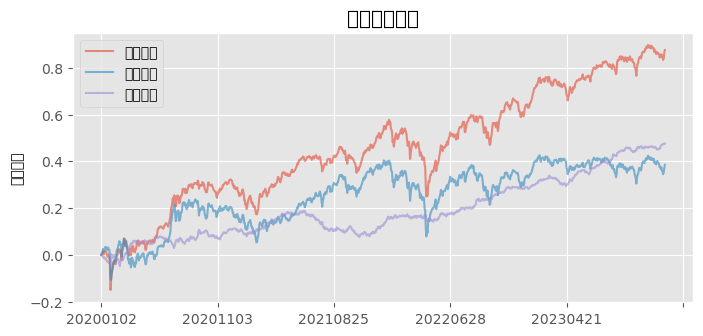

,指数收益,超额收益,策略收益
年化收益率,0.099,0.123,0.226
年化波动率,0.201,0.074,0.195
夏普率,0.495,1.665,1.157
最大回撤,-0.325,-0.112,-0.328
收益回撤比,0.305,1.099,0.688
胜率,0.534,0.538,0.566
盈亏比,0.948,1.138,0.938


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


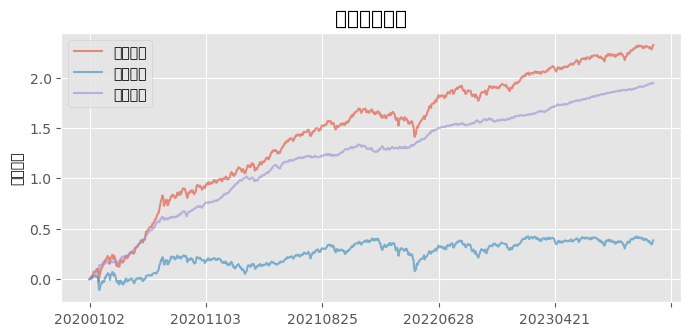

,指数收益,超额收益,策略收益
年化收益率,0.099,0.501,0.599
年化波动率,0.201,0.097,0.230
夏普率,0.495,5.183,2.609
最大回撤,-0.325,-0.076,-0.283
收益回撤比,0.305,6.608,2.115
胜率,0.534,0.649,0.602
盈亏比,0.948,1.324,1.031


Program 3: add(div(VolStd, bias5), sub(div(bias15, std240), abs(ma5)))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


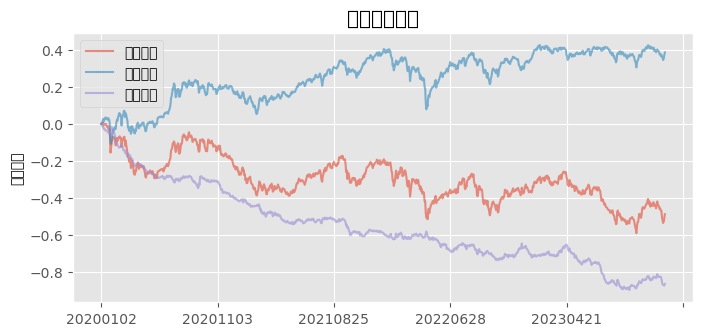

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.223,-0.126
年化波动率,0.201,0.110,0.240
夏普率,0.495,-2.027,-0.525
最大回撤,-0.325,-0.893,-0.595
收益回撤比,0.305,-0.249,-0.211
胜率,0.534,0.451,0.525
盈亏比,0.948,0.862,0.827


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


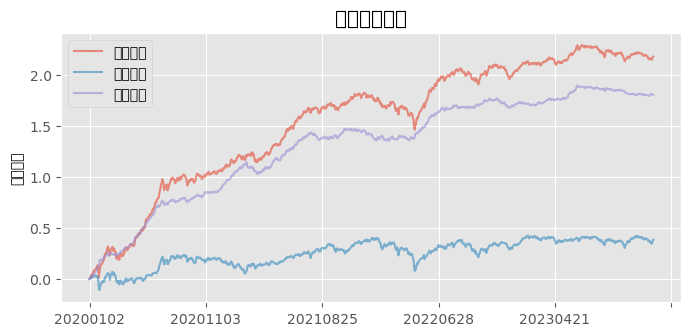

,指数收益,超额收益,策略收益
年化收益率,0.099,0.465,0.562
年化波动率,0.201,0.132,0.248
夏普率,0.495,3.519,2.263
最大回撤,-0.325,-0.119,-0.362
收益回撤比,0.305,3.906,1.552
胜率,0.534,0.588,0.580
盈亏比,0.948,1.281,1.053


Program 4: add(sub(up_plus_down_KURS, buy_elg_amount), div(bias15, std240))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


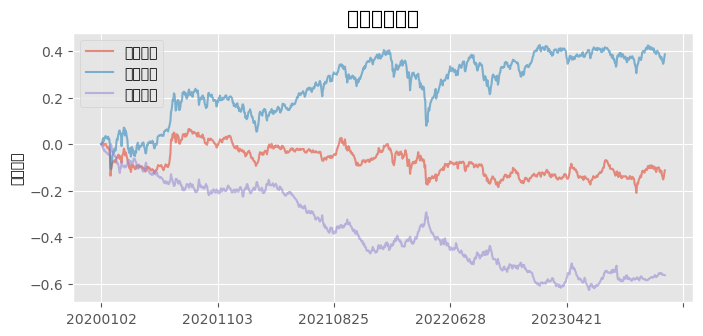

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.145,-0.029
年化波动率,0.201,0.126,0.150
夏普率,0.495,-1.154,-0.194
最大回撤,-0.325,-0.626,-0.274
收益回撤比,0.305,-0.232,-0.106
胜率,0.534,0.442,0.498
盈亏比,0.948,1.045,0.972


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


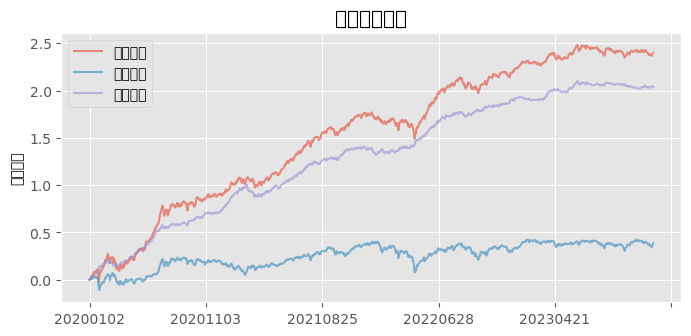

,指数收益,超额收益,策略收益
年化收益率,0.099,0.525,0.618
年化波动率,0.201,0.134,0.263
夏普率,0.495,3.905,2.355
最大回撤,-0.325,-0.133,-0.278
收益回撤比,0.305,3.942,2.225
胜率,0.534,0.586,0.584
盈亏比,0.948,1.366,1.057


Program 5: add(add(turnover_rate_proportion_l, roc15), sqrt(amt_score0))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


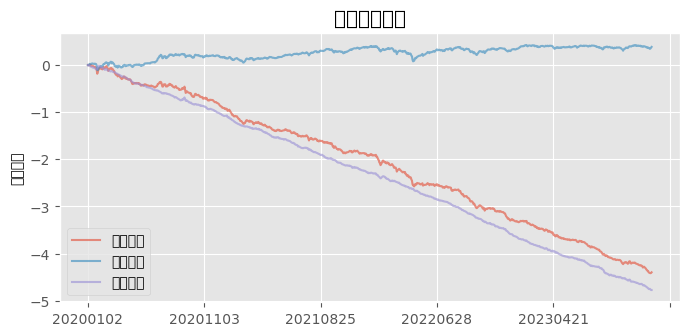

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.230,-1.133
年化波动率,0.201,0.121,0.247
夏普率,0.495,-10.160,-4.588
最大回撤,-0.325,-4.765,-4.426
收益回撤比,0.305,-0.258,-0.256
胜率,0.534,0.244,0.396
盈亏比,0.948,0.567,0.693


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


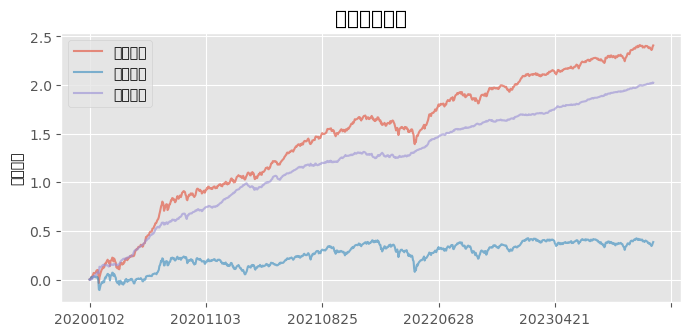

,指数收益,超额收益,策略收益
年化收益率,0.099,0.522,0.621
年化波动率,0.201,0.095,0.223
夏普率,0.495,5.508,2.782
最大回撤,-0.325,-0.067,-0.295
收益回撤比,0.305,7.803,2.105
胜率,0.534,0.678,0.607
盈亏比,0.948,1.265,1.040


Program 6: add(tailrets1, add(div(UTD20, growth_a), mul(draw30, add(rank(ivr), ARRP_5d_20mean))))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


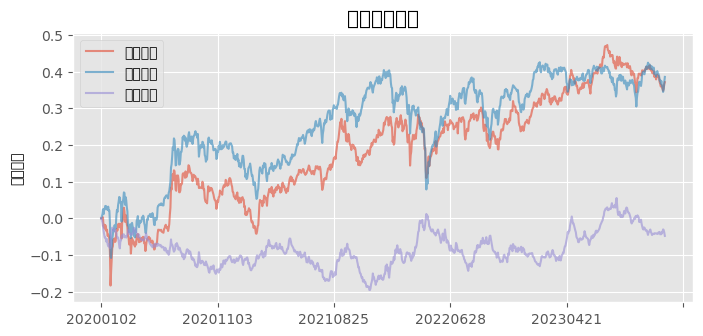

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.012,0.096
年化波动率,0.201,0.111,0.188
夏普率,0.495,-0.111,0.508
最大回撤,-0.325,-0.191,-0.187
收益回撤比,0.305,-0.065,0.512
胜率,0.534,0.472,0.538
盈亏比,0.948,1.096,0.937


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


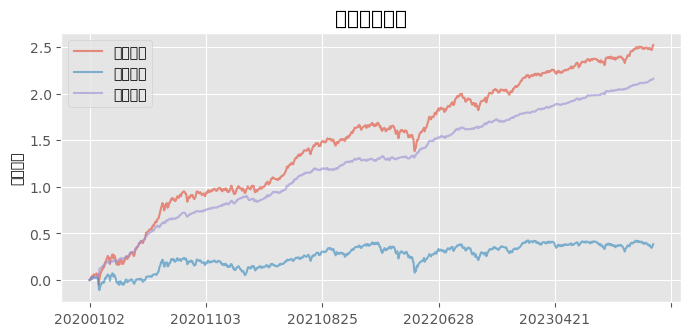

,指数收益,超额收益,策略收益
年化收益率,0.099,0.558,0.651
年化波动率,0.201,0.100,0.248
夏普率,0.495,5.592,2.619
最大回撤,-0.325,-0.065,-0.306
收益回撤比,0.305,8.595,2.130
胜率,0.534,0.668,0.584
盈亏比,0.948,1.327,1.111


Program 7: add(sub(tailrets0, TCV), sub(up_plus_down_KURS, sqrt(buy_lg_amount)))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


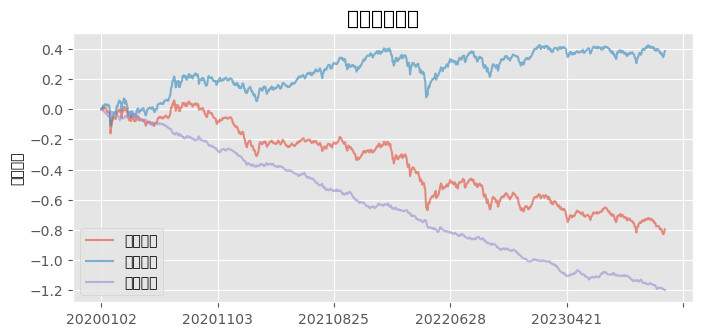

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.309,-0.205
年化波动率,0.201,0.075,0.194
夏普率,0.495,-4.104,-1.057
最大回撤,-0.325,-1.196,-0.887
收益回撤比,0.305,-0.258,-0.231
胜率,0.534,0.369,0.495
盈亏比,0.948,0.872,0.845


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


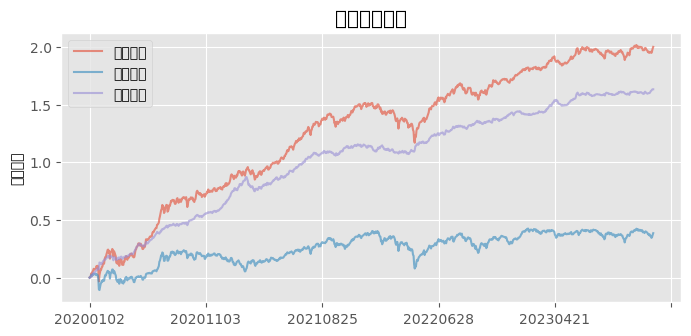

,指数收益,超额收益,策略收益
年化收益率,0.099,0.421,0.516
年化波动率,0.201,0.120,0.252
夏普率,0.495,3.522,2.049
最大回撤,-0.325,-0.123,-0.345
收益回撤比,0.305,3.413,1.496
胜率,0.534,0.593,0.586
盈亏比,0.948,1.234,1.000


Program 8: div(add(rank(stddev_cov), neg(ll120)), rank(div(tailrets1, tailrets0)))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


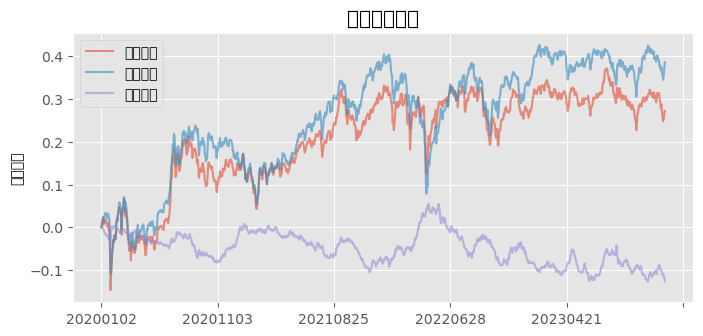

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.033,0.070
年化波动率,0.201,0.077,0.199
夏普率,0.495,-0.424,0.351
最大回撤,-0.325,-0.182,-0.205
收益回撤比,0.305,-0.179,0.342
胜率,0.534,0.465,0.529
盈亏比,0.948,1.070,0.946


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


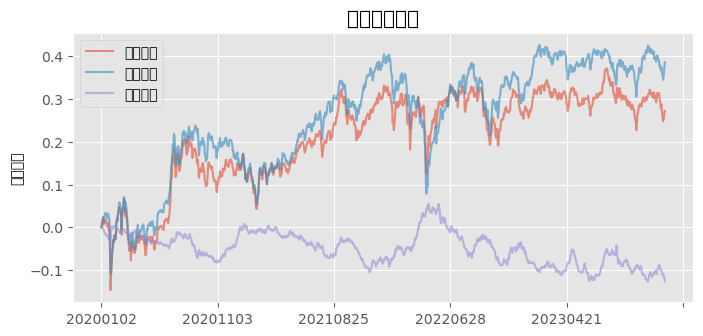

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.033,0.070
年化波动率,0.201,0.077,0.199
夏普率,0.495,-0.424,0.351
最大回撤,-0.325,-0.182,-0.205
收益回撤比,0.305,-0.179,0.342
胜率,0.534,0.465,0.529
盈亏比,0.948,1.070,0.946


Program 9: div(div(tailrets1, tailrets0), lowr)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


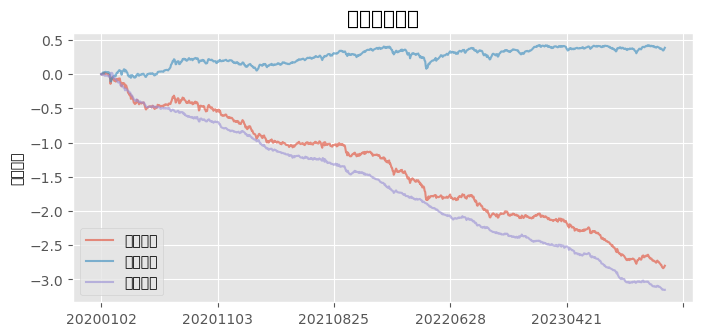

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.812,-0.721
年化波动率,0.201,0.163,0.291
夏普率,0.495,-4.998,-2.483
最大回撤,-0.325,-3.173,-2.851
收益回撤比,0.305,-0.256,-0.253
胜率,0.534,0.365,0.435
盈亏比,0.948,0.746,0.855


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


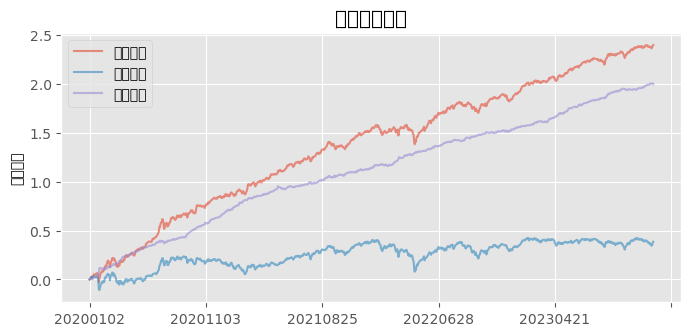

,指数收益,超额收益,策略收益
年化收益率,0.099,0.515,0.617
年化波动率,0.201,0.076,0.197
夏普率,0.495,6.779,3.142
最大回撤,-0.325,-0.033,-0.198
收益回撤比,0.305,15.765,3.111
胜率,0.534,0.668,0.624
盈亏比,0.948,1.624,1.026


Program 10: log(add(sqrt(amt_score0), draw15))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


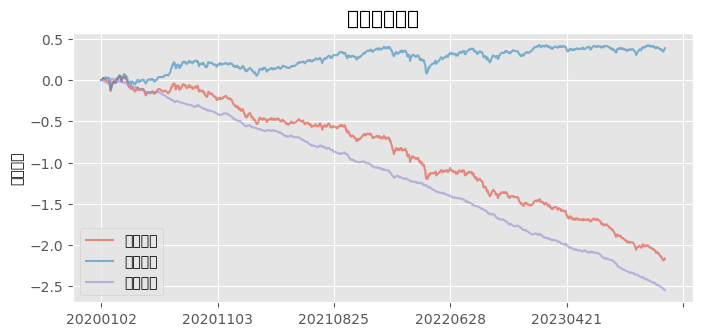

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.656,-0.558
年化波动率,0.201,0.083,0.222
夏普率,0.495,-7.868,-2.506
最大回撤,-0.325,-2.563,-2.236
收益回撤比,0.305,-0.256,-0.249
胜率,0.534,0.300,0.459
盈亏比,0.948,0.638,0.771


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


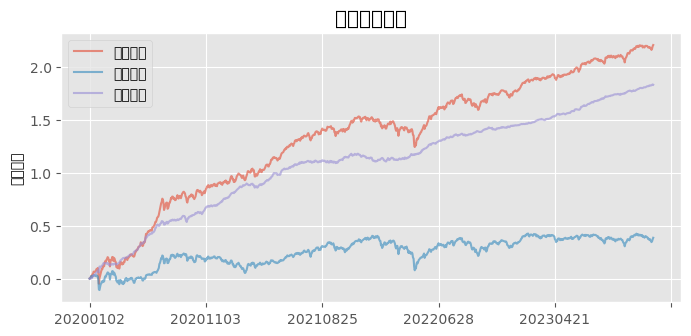

,指数收益,超额收益,策略收益
年化收益率,0.099,0.472,0.568
年化波动率,0.201,0.094,0.233
夏普率,0.495,5.028,2.444
最大回撤,-0.325,-0.074,-0.289
收益回撤比,0.305,6.387,1.964
胜率,0.534,0.652,0.602
盈亏比,0.948,1.283,1.002


In [19]:
transformed_factor = []
for i, program in enumerate(test_gp._best_programs):
    print(f'Program {i+1}: {program}')
    transformed_X = program.execute(np.nan_to_num(stock_all.loc[:,fields].values))
    transformed_factor_X = pd.DataFrame(transformed_X.reshape(close.shape[0],-1),index = close.index,columns = close.loc[:,'20200101':'20240101'].columns)
    a = ff.run(-transformed_factor_X*ff.filter1.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0)[0]
    b = ff.run(transformed_factor_X*ff.filter1.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0)[0]
    if a.iloc[0,2] > 0:
        result.loc[len(result)] = ('-'+str(program),a.iloc[2,2],a.iloc[0,2],10)
    else:
        result.loc[len(result)] = (str(program),b.iloc[2,2],b.iloc[0,2],10)

In [20]:
for i, program in enumerate(test_gp._best_programs):
    print(f'Program {i+1}: {program}')
    if i == 6:
        transformed_X = program.execute(np.nan_to_num(stock_all.loc[:,fields].values))
        transformed_factor_X_5 = pd.DataFrame(transformed_X.reshape(close.shape[0],-1),index = close.index,columns = close.loc[:,'20200101':'20240101'].columns)

Program 1: sub(bias15, ctrade)
Program 2: add(bias15, div(amt_score0, sqrt(buy_sm_amount)))
Program 3: add(div(VolStd, bias5), sub(div(bias15, std240), abs(ma5)))
Program 4: add(sub(up_plus_down_KURS, buy_elg_amount), div(bias15, std240))
Program 5: add(add(turnover_rate_proportion_l, roc15), sqrt(amt_score0))
Program 6: add(tailrets1, add(div(UTD20, growth_a), mul(draw30, add(rank(ivr), ARRP_5d_20mean))))
Program 7: add(sub(tailrets0, TCV), sub(up_plus_down_KURS, sqrt(buy_lg_amount)))
Program 8: div(add(rank(stddev_cov), neg(ll120)), rank(div(tailrets1, tailrets0)))
Program 9: div(div(tailrets1, tailrets0), lowr)
Program 10: log(add(sqrt(amt_score0), draw15))


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0.0005
交易模式： t日收盘价买入，收盘价卖出


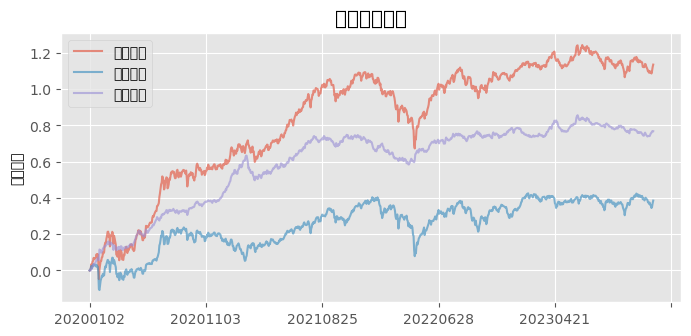

,指数收益,超额收益,策略收益
年化收益率,0.099,0.198,0.293
年化波动率,0.201,0.119,0.252
夏普率,0.495,1.658,1.163
最大回撤,-0.325,-0.163,-0.421
收益回撤比,0.305,1.212,0.696
胜率,0.534,0.537,0.556
盈亏比,0.948,1.134,0.973


,指数收益,超额收益,策略收益
年化收益率,0.099,0.198,0.293
年化波动率,0.201,0.119,0.252
夏普率,0.495,1.658,1.163
最大回撤,-0.325,-0.163,-0.421
收益回撤比,0.305,1.212,0.696
胜率,0.534,0.537,0.556
盈亏比,0.948,1.134,0.973


In [21]:
ff.run(transformed_factor_X_5*ff.filter1.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0.0005)[0]